In [1]:
import xarray as xr
from matplotlib import pyplot as plt
import numpy as np
%load_ext autoreload
%autoreload 2
import pei.laborfunctions as lf
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib.cm as cm
from dask.diagnostics import ProgressBar
plt.style.use('/home/aos/kyan/.config/matplotlib/esm2m.mplstyle')

# Calculate ESM2M Baseline

In [2]:
# Load ESM2M labor capacity data
ds_esm2m = xr.open_mfdataset('../data/processed/GFDL/Monthly_Capacity/monthly_capacity_ens*_1950-2100.nc',combine='nested',concat_dim='ensemble',chunks={'time':1095})
ds_esm2m = ds_esm2m.rename({'__xarray_dataarray_variable__':'capacity'})

In [ ]:
# Calculate 1980-2000 baseline by month
with ProgressBar():
    ds_base_esm2m = lf.calc_baseline(ds_esm2m).compute()

In [5]:
ds_base_esm2m = xr.open_dataarray('../data/processed/GFDL/esm2m_baseline_hottestmonths.nc')

In [7]:
ds_base_cesm2 = xr.open_dataarray('../data/processed/CESM2/cesm2_baseline_hottestmonths.nc')

Text(0.5, 0.98, '1980-2000 Labor Capacity Baseline')

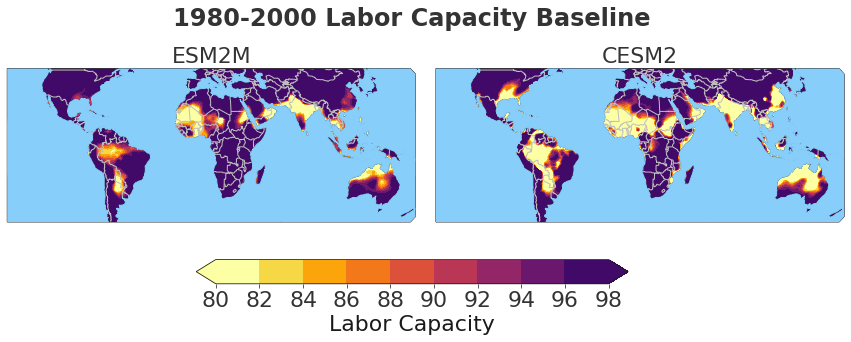

In [21]:
crs = ccrs.Robinson()

fig,ax=plt.subplots(ncols=2,figsize=(15,4.5),subplot_kw={'projection':crs})
levels = np.arange(80,100,2)

cmap = cm.get_cmap('inferno_r')
colors= cmap(np.arange(0,1,0.1))

im = lf.contour(ds_base_esm2m,'ESM2M',ax[0],levels=levels,colors=colors,over=None,crop=True)
lf.contour(ds_base_cesm2,'CESM2',ax[1],levels=levels,colors=colors,over=None,crop=True)

# Single colorbar for all plots
fig.subplots_adjust(bottom=0.225)
cbar_ax = fig.add_axes([0.3, 0.125, 0.4, 0.075])
cbar = fig.colorbar(im, cax=cbar_ax,orientation='horizontal');
cbar.set_label('Labor Capacity',fontsize=22)
fig.subplots_adjust(wspace=.05,hspace=.05)
fig.suptitle('1980-2000 Labor Capacity Baseline',fontweight='bold')

# Calculate CESM2 Baseline

In [10]:
# Load ESM2M labor capacity data
ds_cesm2 = xr.open_mfdataset('../data/processed/CESM2/Monthly_Capacity/*',combine='nested',concat_dim='ensemble',chunks={'time':1000}).rename({'__xarray_dataarray_variable__':'capacity'})

In [11]:
# Calculate 1980-2000 baseline by month
with ProgressBar():
    ds_base_cesm2 = lf.calc_baseline(ds_cesm2).compute()

[########################################] | 100% Completed |  3min 32.7s


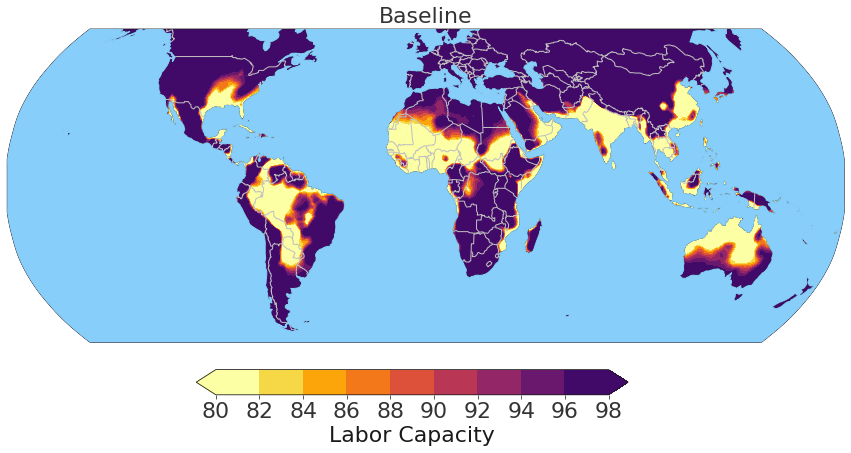

In [12]:
crs = ccrs.Robinson()

fig,ax=plt.subplots(figsize=(15,7),subplot_kw={'projection':crs})
ds_base = ds_base_cesm2
months = ['January','February','March','April','May','June','July','August','September','October','November','December']
levels = np.arange(80,100,2)

cmap = cm.get_cmap('inferno_r')
colors= cmap(np.arange(0,1,0.1))

im = lf.contour(ds_base,'Baseline',ax,levels=levels,colors=colors,over=None,crop=True)

# Single colorbar for all plots
fig.subplots_adjust(bottom=0.2)
cbar_ax = fig.add_axes([0.3, 0.125, 0.4, 0.05])
cbar = fig.colorbar(im, cax=cbar_ax,orientation='horizontal');
cbar.set_label('Labor Capacity',fontsize=22)
fig.subplots_adjust(wspace=.05,hspace=.05)

In [13]:
ds_base_cesm2.to_netcdf('../data/processed/CESM2/cesm2_baseline_hottestmonths.nc')